In [ ]:
from ecell4 import *
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct,L,conc,shift,Da,Db,save):
        import numpy as np
        from math import sqrt
        rm = 0.005
        run+=shift
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        D = 1
        kd= 4.0*math.pi*D
        ka = kaf*kd
        f=1.0208582         
        if correct=='new':
            gamma=0.577216
            factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
            PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor            
        voxelr=rm*f
        tm =(2*voxelr)**2/(4*D)        
        duration=0.0035#1e-2#0.2#tm*5e4#tm*5e3
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
        Nmv=size[1]*size[2]
        lx,ly,lz=w.actual_lengths()
        N=423#int(conc*ly*lz)
        Na=N
        Nb=N#int(5*Na)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        with species_attributes():
            A |  {'D': str(Da), 'radius':str(voxelr),'location':'M'}
            B |  {'D': str(Db), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():
            A + B > B | ka

        m2 = get_model()
        w.bind_to(m2)
        w.add_molecules(Species('A'), Na)
        w.add_molecules(Species('B'), Nb)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        tfactor=5
        time=np.linspace(0.0013,0.003,20)
        obs = TimingNumberObserver(time,['A'])
        sim.run(duration,obs)       
        data=obs.data()
        return 
    job.update({'run':task_id})
    out=singlerun(**job)
    return       

simrun=60*1000#20000
kaf=100
nproc=60#250#
L=6.5
#shift=60*100
Da=1
Db=0
save=True
for conc in [2.37]:#2.37,4,10
    for cor in ['new']:#,'new']:
        jobs=[{'kaf':kaf,'correct':cor,'conc':conc,'L':L,'shift':shift,'Da':Da,'Db':Db,'save':save}]    
        ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

conc 9.981146722856826
/home/chew/outputdata/keff/2D/newkfac100_N423_L6.5_50tm_1.0208582rm/*
nosimrun 4000
/home/chew/outputdata/2ndpaper/irrxn_kt_kf=100
/home/chew/outputdata/keff/2D/newkfac0.01_N423_L6.5_50tm_1.0208582rm/*
nosimrun 4000
/home/chew/outputdata/2ndpaper/irrxn_kt_kf=0.01


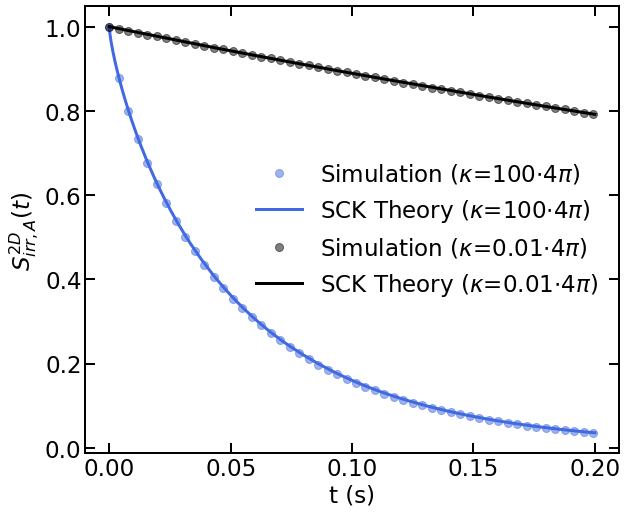

In [2]:
import glob
import numpy as np
import os.path
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

L=6.5
f=1.0208582
kaf=100
NN=423
Area=42.3799
conc = NN/Area
print('conc',conc)
ks=[100,0.01]

def calk(stsim,t,C): #get kt from st
    dst = (stsim[2:]-stsim[:-2])/(t[2:]-t[:-2])
    dst=np.append((stsim[1]-stsim[0])/(t[1]-t[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2])/(t[-1]-t[-2])  )
    return -dst/stsim/C

def getst(N,pattern,ds):   
    fns = glob.glob(pattern)
    fns=fns[:4000]
    y=0
    tlast=0
    for fn in fns:
        r=np.loadtxt(fn,delimiter=',')
        y+=np.array(r).T[1][::ds]
        if tlast==0:
            tlast=np.array(r).T[0][-1]
        assert(tlast==np.array(r).T[0][-1])
    x=np.array(r).T[0][::ds]
    print('nosimrun',len(fns))
    y/=float(len(fns))
    s=y/float(N)
    return x,s       

tend=0.2
D=1
rm=0.005
kd= 4.0*pi*D
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
mks = ['s','o']
ls=['--','-']
c=['royalblue','k']
for i,kaf in enumerate(ks):
    mk=mks[i]
    ka=kaf*kd
    pattern = '/home/chew/outputdata/keff/2D/newkfac{}_N{}_L{}_50tm_{}rm/*'.format(kaf,NN,L,f)
    print(pattern)
    t,st=getst(NN,pattern,1)    
    st=st[t<tend]
    t=t[t<tend] 
    ds=3
    ax.plot(t[::ds],st[::ds],'.',color=c[i],linestyle=' ',label='Simulation ($\kappa$={}$\cdot$4$\pi$)'.format(kaf),markersize=ms,alpha=0.5)
#load continuum data
    name = '/home/chew/outputdata/2ndpaper/stck_kf{}.csv'.format(kaf)
    T,ST = np.loadtxt(name,delimiter=',').T   
    ax.plot(T,ST,'-',color=c[i],label='SCK Theory ($\kappa$={}$\cdot$4$\pi$)'.format(kaf),linewidth=lw)
    kt = calk(st,t,conc)
    name = '/home/chew/outputdata/2ndpaper/irrxn_kt_kf={}'.format(kaf)
    print(name)
    #filename=open(name,'w')
    #np.savetxt(name,[t,kt],delimiter=',',fmt='%s')
    #filename.close()   
ax.set_xlabel('t (s)',fontsize=fs)
ax.set_ylabel('$S_{irr,A}^{2D}(t)$ ',fontsize=fs)
#ax.legend(loc='best',fontsize=fs)
ax.legend(fontsize=fs,loc='best',frameon=0)
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both',which='both',direction='in',length=10,width=2)
#plt.savefig("/home/chew/ecellwork/figure/2ndpaper/fig1b.pdf",format='pdf',dpi=800)        

0.0013026893306340498
[0.12165 0.12162 0.1216 ] [0.0013027 0.0013287 0.0013548]
[0.12317756 0.12279013 0.12089251] [0.         0.00130269 0.00260538]
0.0013894736842105264
[3.1182 3.106  3.094 ] [0.0014069 0.001433  0.001459 ]
[3.12997723 3.10826104 3.05210571] [0.0013     0.00138947 0.00147895]


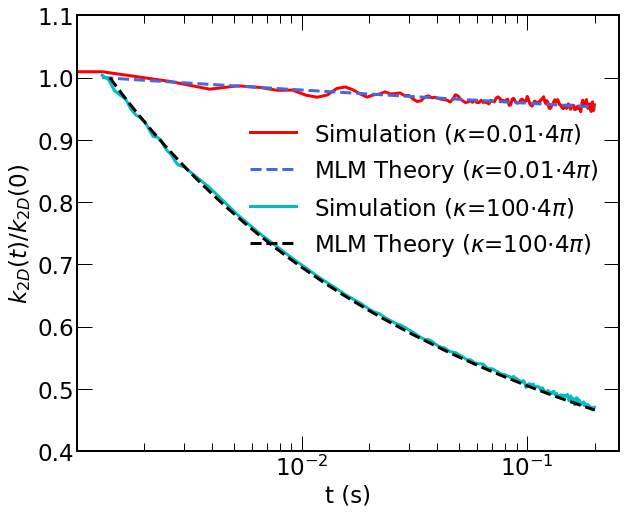

In [4]:
import glob
import numpy as np
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
ks=[0.01,100]
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
D=1
rm=0.005
kd= 4.0*pi*D
R=0.01
f=1.0208582
l=R*f
td=l*l/4/D
mks = ['s','o']
ls=['--','-']
cs=['r','c']
c=['royalblue','k']
for i,kaf in enumerate(ks):
    mk=mks[i]
    ka = kaf*kd
    name = '/home/chew/outputdata/2ndpaper/irrxn_kt_kf={}'.format(kaf)
    t,kt = np.loadtxt(name,delimiter=',')    
    firstt=t[1]
    print(firstt)
    name = '/home/chew/outputdata/2ndpaper/ktL_kf{}.csv'.format(kaf)
    T,KT = np.loadtxt(name,delimiter=',').T   
    KT=KT[T>firstt]
    T=T[T>firstt]
    print(KT[:3],T[:3])
    print(kt[:3],t[:3])
    first=KT[0]
    ax.plot(t,kt/first,'-',c=cs[i],label='Simulation ($\kappa$={}$\cdot$4$\pi$)'.format(kaf),linewidth=lw)
    ax.semilogx(T,KT/first,'--',c=c[i],label='MLM Theory ($\kappa$={}$\cdot$4$\pi$)'.format(kaf),linewidth=lw)
ax.set_xlabel('t (s)',fontsize=fs)
ax.set_ylabel('$k_{2D}(t)/k_{2D}(0)$',fontsize=fs)
ax.set_ylim(0.4,1.1)
#ax.legend(loc=7,fontsize=fs)
ax.legend(fontsize=fs,loc='center right', bbox_to_anchor=(1, 0.6),frameon=0)
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both', which='major', direction='in',length=15,width=1)
ax.tick_params(axis='both', which='minor', direction='in',length=8,width=1)
plt.savefig("/home/chew/ecellwork/figure/2ndpaper/fig1a.pdf",format='pdf',dpi=800)    